# Living Income Analysis

First we load all libraries to be used:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  
from sklearn.cluster import KMeans

from sklearn.impute import SimpleImputer

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import seaborn as sns#; sns.set(style="ticks", color_codes=True)
current_palette = sns.color_palette()

from scipy.stats import variation

import json

## Data Import and initial feature  & observation selection

Load the data from stata, which has already been partially cleaned/treated, since it comes from a curated public data repository.

The dataset is extracted from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/82TWZJ
in stata 14 binary format.

It is part of the research project described more broadly at https://www.kit.nl/project/demystifying-cocoa-sector/

In [2]:
data = pd.read_stata("Cocoa_Livelihoods_export_Dataverse.dta") # data
data_properties = pd.read_stata("Cocoa_Livelihoods_export_Dataverse.dta", iterator = True) #meta data

We initialliy inspect the data:

In [3]:
print("Shape of data set:", data.shape)

Shape of data set: (3045, 1252)


First few rows

In [4]:
data.head(10)

,today,country,region_comparable,up_region,region,sub_region,village,latitude,longitude,consent_yn,...,foodsec_bin_3,foodsec_bin_4,foodsec_bin_5,foodsec_bin_6,foodsec_bin_7,foodsec_bin_8,foodsec_bin_9,foodsec_bin_10,foodsec_bin_11,foodsec_bin_12
0,26-dec-16,Ghana,Ashanti,Ghana,Ashanti,Atwima Mponua,Agogoso,6.61,-2.07,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
1,27-dec-16,Ghana,Ashanti,Ghana,Ashanti,Atwima Nwabiagya,Toase,NaN,NaN,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
2,04-dec-16,Ghana,Ashanti,Ghana,Ashanti,Adansi West,Ampunyasi,6.04,-1.76,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
3,03-dec-16,Ghana,Ashanti,Ghana,Ashanti,Bosomtwi Kwanwoma,Nyameani,NaN,NaN,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
4,03-dec-16,Ghana,Ashanti,Ghana,Ashanti,Bosomtwi Kwanwoma,Nyameani,6.57,-1.43,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
5,2-dec-2016,Ghana,Ashanti,Ghana,Ashanti,Adansi East,Aboabo 2,6.22,-1.35,yes,...,no,no,yes,yes,yes,yes,yes,yes,yes,yes
6,03-dec-16,Ghana,Ashanti,Ghana,Ashanti,Bosomtwi Kwanwoma,Nyameani,6.57,-1.43,yes,...,no,no,no,no,no,no,no,no,no,no
7,27-dec-16,Ghana,Ashanti,Ghana,Ashanti,Atwima Nwabiagya,Toase,6.66,-1.81,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
8,29-dec-16,Ghana,Ashanti,Ghana,Ashanti,Afigya Sekyere,Jamaase,NaN,NaN,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
9,04-dec-16,Ghana,Ashanti,Ghana,Ashanti,Adansi West,Ampunyasi,6.04,-1.76,yes,...,no,no,no,no,yes,yes,yes,no,yes,yes


See some descriptive statistics

In [5]:
data.describe()

,latitude,longitude,hhmem_number,male_adults_over_65,female_adults_over_65,male_adults_15_65,female_adults_15_65,male_children_5_14,female_children_5_14,male_children_0_4,...,dhs_combined,PPI_SCORE,PPI_100_Nat,PPI_125dollar_day,PPI_200dollar_day,PPI_250dollar_day,PPI_190dollar_day,PPI_310dollar_day,non_cocoa_land,share_cocoa_land
count,2210.000000,2210.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,...,2435.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,1545.000000,1545.000000,1887.000000,1887.000000
mean,6.429661,-4.112733,6.264314,0.142144,0.147803,1.689747,1.705726,0.981025,0.868842,0.374501,...,-0.291392,44.137032,30.232420,14.947255,33.256577,44.436817,7.543701,24.523375,1.705683,0.732727
std,0.697673,1.894443,3.200178,0.374114,0.402447,1.247421,1.181760,1.123111,1.099499,0.681247,...,0.487034,13.002094,22.378967,16.871199,28.074274,31.169250,9.881251,20.898497,2.309870,0.238368
min,4.840000,-8.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.672072,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632
25%,5.940000,-5.447500,4.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,-0.605459,35.000000,11.700000,0.600000,5.300000,12.800000,0.900000,5.800000,0.000000,0.555556
50%,6.470000,-3.870000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,-0.363614,43.000000,28.900000,7.200000,27.100000,41.299999,2.400000,16.100000,0.980000,0.750000
75%,6.930000,-2.500000,8.000000,0.000000,0.000000,2.000000,2.000000,2.000000,1.000000,1.000000,...,-0.055659,53.000000,50.700001,27.100000,59.400002,74.099998,7.900000,35.400002,2.296600,1.000000
max,7.840000,-0.470000,21.000000,5.000000,5.000000,9.000000,9.000000,7.000000,7.000000,5.000000,...,2.926933,98.000000,87.599998,71.500000,93.900002,97.199997,50.700001,81.699997,17.000000,1.000000


Take a look at the full list of variables and variable labels:

In [6]:
print(json.dumps(data_properties.variable_labels(), indent=1))

{
 "today": "Interview date",
 "country": "Country",
 "region_comparable": "Comparable regions",
 "up_region": "Country (Ghana) / District (CdI)",
 "region": "Region",
 "sub_region": "District (Ghana) / Departement (Cdi)",
 "village": "Village",
 "latitude": "Latitude",
 "longitude": "Longitude",
 "consent_yn": "Consent to participate",
 "hhmem_number": "Number of household members living in the compound",
 "male_adults_over_65": "Number of males over 65 years old",
 "female_adults_over_65": "Number of females over 65 years old",
 "male_adults_15_65": "Number of males 15-65",
 "female_adults_15_65": "Number of females between 15 and 65 years old",
 "male_children_5_14": "Number of boys between 15 and 65 years old",
 "female_children_5_14": "Number of girls  between 5 and 14 years old",
 "male_children_0_4": "Number of boys younger than 4 years old",
 "female_children_0_4": "Number of girls younger than 4 years old",
 "dep_ratio": "Dependency ratio",
 "head_age": "Head: age",
 "head_age

The detailed cocoa production goes is built over a few production activities. We will create a list with those activities for further iteration in this notebook

In [27]:
production_activities = [
'landclear',
'landprep',
'planting',
'gfert',
'lfert',
'manurecomp',
'herb',
'pest',
'fung',
'weed',
'pruning',
'harvest',
'threshing',
'winnowing',
'transport',
]

The full dataset has (too) many features (1252). This includes features which are not useful for the analysis, and some are sets of dummy variables (which is fine).

We will first drop features that I know I will not be needing for any of the analysis.

They include:
- location variables, except country. Analysis will be on a country level
- consent indicator, as this should be 'yes' for all observations included in this dataset
- instanceid, unique identifier
- data on the respondent (data on the head of the household and on the full household will suffice)
- variables in imputed values ("fm_"), since the imputation was done based on the country level, and I will do this by other 
groups
- indicator of selling crops for the subset of those that produced: this variable carries by construction many missing values (those that did not produce) and therefore is not of interest
- variables with daily rates for hired labour, since the original reports refer they used median hiring cost to adjust for noise in the responses
- question on the "days known" for labour activities, since these are intermediary variables to filter on the amount of days and therefore not needed for this analysis


Confirm `consent` is `yes` for all obs

In [7]:
data['consent_yn'].value_counts()

yes    3045
Name: consent_yn, dtype: int64

In [8]:
data.drop(['region_comparable', 'up_region', 'sub_region', 'village', 'latitude', 'longitude'], axis = 1, inplace = True) # drop location variables
data.drop(['today','consent_yn', 'instanceid'], axis = 1, inplace = True) # drop id variables
data.drop(list(data.filter(regex = 'p1_')), axis = 1, inplace = True) # drop respondent variables
data.drop(list(data.filter(regex = 'fm_')), axis = 1, inplace = True) # drop farm model imputed variables
data.drop(list(data.filter(regex = 'crops_sold_ifprod')), axis = 1, inplace = True) # drop indicator subset for farmers that did produce a crop
data.drop(list(data.filter(regex = 'orig_hi_cost')), axis = 1, inplace = True) # drop farm model imputed variables
data.drop(list(data.filter(regex = 'daysknown_yn')), axis = 1, inplace = True) # drop farm model imputed variables

For each production activity there is also two sex of workers indicators (`_gender_1, _gender_2`), plus a combined indicator (`_gender`). We can drop the latter.

In [9]:
list(data.filter(regex = 'gender'))

['head_gender',
 'cocoa_landclear_gender_1',
 'cocoa_landclear_gender_2',
 'cocoa_landclear_gender',
 'cocoa_landprep_gender_1',
 'cocoa_landprep_gender_2',
 'cocoa_landprep_gender',
 'cocoa_planting_gender_1',
 'cocoa_planting_gender_2',
 'cocoa_planting_gender',
 'cocoa_gfert_gender_1',
 'cocoa_gfert_gender_2',
 'cocoa_gfert_gender',
 'cocoa_lfert_gender_1',
 'cocoa_lfert_gender_2',
 'cocoa_lfert_gender',
 'cocoa_manurecomp_gender_1',
 'cocoa_manurecomp_gender_2',
 'cocoa_manurecomp_gender',
 'cocoa_herb_gender_1',
 'cocoa_herb_gender_2',
 'cocoa_herb_gender',
 'cocoa_pest_gender_1',
 'cocoa_pest_gender_2',
 'cocoa_pest_gender',
 'cocoa_fung_gender_1',
 'cocoa_fung_gender_2',
 'cocoa_fung_gender',
 'cocoa_weed_gender_1',
 'cocoa_weed_gender_2',
 'cocoa_weed_gender',
 'cocoa_pruning_gender_1',
 'cocoa_pruning_gender_2',
 'cocoa_pruning_gender',
 'cocoa_harvest_gender_1',
 'cocoa_harvest_gender_2',
 'cocoa_harvest_gender',
 'cocoa_podbreak_gender_1',
 'cocoa_podbreak_gender_2',
 'cocoa

In [10]:
data.drop([
 'cocoa_landclear_gender',
 'cocoa_landprep_gender',
 'cocoa_planting_gender',
 'cocoa_gfert_gender',
 'cocoa_lfert_gender',
 'cocoa_manurecomp_gender',
 'cocoa_herb_gender',
 'cocoa_pest_gender',
 'cocoa_fung_gender',
 'cocoa_weed_gender',
 'cocoa_pruning_gender',
 'cocoa_harvest_gender',
 'cocoa_podbreak_gender',
 'cocoa_ferment_gender',
 'cocoa_transport_gender',
 'cocoa_decisions_gender',
 'cocoa_marketing_gender'
], axis = 1, inplace = True)

Similarly, for each production activity there is also four types of workers indicators (`hhhiredcom_`), plus a combined indicator (`hh_hi`). In this case, since the two cases covered by the combined are more relevant than the individual four (and make the dataset more manageable), we will keep only the combined indicator

In [11]:
data.drop(list(data.filter(regex = 'hhhiredcom_')), axis = 1, inplace = True) # drop respondent variables

For the analysis, we will only look at cocoa households that know their land and production

In [12]:
data = data[data['cocoa_hh']=='yes']
data = data[data['cocoa_land_known_yn']=='yes']

In [13]:
data.drop(['cocoa_hh', 'cocoa_land_known_yn'], axis = 1, inplace = True)

Now we can also drop some of the other household type indicators, since we are only looking at cocoa households

In [14]:
list(data.filter(regex = '_hh'))

['coconut_hh',
 'cocoyam_hh',
 'coffee_hh',
 'courgette_hh',
 'cotton_hh',
 'cow_pea_hh',
 'eggplant_hh',
 'fodder_hh',
 'garlic_hh',
 'ginger_hh',
 'groundnuts_hh',
 'lemon_hh',
 'lime_hh',
 'maize_hh',
 'mango_hh',
 'millet_hh',
 'okra_hh',
 'onions_hh',
 'oranges_hh',
 'palm_hh',
 'papaya_hh',
 'peas_hh',
 'peppers_hh',
 'pineapple_hh',
 'plantai_hh',
 'irish_potato_hh',
 'sweet_potato_hh',
 'rice_hh',
 'rubber_hh',
 'spinach_hh',
 'sorghum_hh',
 'shea_nut_hh',
 'sugar_cane_hh',
 'tangerine_hh',
 'tomatoes_hh',
 'watermelon_hh',
 'yam_hh',
 'avocado_hh_5ago',
 'bananas_hh_5ago',
 'soya_beans_hh_5ago',
 'beans_hh_5ago',
 'cabbages_hh_5ago',
 'carrots_hh_5ago',
 'cashews_hh_5ago',
 'cassava_hh_5ago',
 'chili_hh_5ago',
 'cocoa_hh_5ago',
 'coconut_hh_5ago',
 'cocoyam_hh_5ago',
 'coffee_hh_5ago',
 'courgette_hh_5ago',
 'cotton_hh_5ago',
 'cow_pea_hh_5ago',
 'eggplant_hh_5ago',
 'fodder_hh_5ago',
 'garlic_hh_5ago',
 'ginger_hh_5ago',
 'groundnuts_hh_5ago',
 'lemon_hh_5ago',
 'lime_hh_5ago

In [15]:
data.drop(
['coconut_hh',
 'cocoyam_hh',
 'coffee_hh',
 'courgette_hh',
 'cotton_hh',
 'cow_pea_hh',
 'eggplant_hh',
 'fodder_hh',
 'garlic_hh',
 'ginger_hh',
 'groundnuts_hh',
 'lemon_hh',
 'lime_hh',
 'maize_hh',
 'mango_hh',
 'millet_hh',
 'okra_hh',
 'onions_hh',
 'oranges_hh',
 'palm_hh',
 'papaya_hh',
 'peas_hh',
 'peppers_hh',
 'pineapple_hh',
 'plantai_hh',
 'irish_potato_hh',
 'sweet_potato_hh',
 'rice_hh',
 'rubber_hh',
 'spinach_hh',
 'sorghum_hh',
 'shea_nut_hh',
 'sugar_cane_hh',
 'tangerine_hh',
 'tomatoes_hh',
 'watermelon_hh',
 'yam_hh',
 'avocado_hh_5ago',
 'bananas_hh_5ago',
 'soya_beans_hh_5ago',
 'beans_hh_5ago',
 'cabbages_hh_5ago',
 'carrots_hh_5ago',
 'cashews_hh_5ago',
 'cassava_hh_5ago',
 'chili_hh_5ago',
 'cocoa_hh_5ago',
 'coconut_hh_5ago',
 'cocoyam_hh_5ago',
 'coffee_hh_5ago',
 'courgette_hh_5ago',
 'cotton_hh_5ago',
 'cow_pea_hh_5ago',
 'eggplant_hh_5ago',
 'fodder_hh_5ago',
 'garlic_hh_5ago',
 'ginger_hh_5ago',
 'groundnuts_hh_5ago',
 'lemon_hh_5ago',
 'lime_hh_5ago',
 'maize_hh_5ago',
 'mango_hh_5ago',
 'millet_hh_5ago',
 'okra_hh_5ago',
 'onions_hh_5ago',
 'oranges_hh_5ago',
 'palm_hh_5ago',
 'papaya_hh_5ago',
 'peas_hh_5ago',
 'peppers_hh_5ago',
 'pineapple_hh_5ago',
 'plantai_hh_5ago',
 'irish_potato_hh_5ago',
 'sweet_potato_hh_5ago',
 'rice_hh_5ago',
 'rubber_hh_5ago',
 'spinach_hh_5ago',
 'sorghum_hh_5ago',
 'shea_nut_hh_5ago',
 'sugar_cane_hh_5ago',
 'tangerine_hh_5ago',
 'tomatoes_hh_5ago',
 'watermelon_hh_5ago',
 'yam_hh_5ago',
 'avocado_hh_change',
 'bananas_hh_change',
 'soya_beans_hh_change',
 'beans_hh_change',
 'cabbages_hh_change',
 'carrots_hh_change',
 'cashews_hh_change',
 'cassava_hh_change',
 'chili_hh_change',
 'cocoa_hh_change',
 'coconut_hh_change',
 'cocoyam_hh_change',
 'coffee_hh_change',
 'courgette_hh_change',
 'cotton_hh_change',
 'cow_pea_hh_change',
 'eggplant_hh_change',
 'fodder_hh_change',
 'garlic_hh_change',
 'ginger_hh_change',
 'groundnuts_hh_change',
 'lemon_hh_change',
 'lime_hh_change',
 'maize_hh_change',
 'mango_hh_change',
 'millet_hh_change',
 'okra_hh_change',
 'onions_hh_change',
 'oranges_hh_change',
 'palm_hh_change',
 'papaya_hh_change',
 'peas_hh_change',
 'peppers_hh_change',
 'pineapple_hh_change',
 'plantai_hh_change',
 'irish_potato_hh_change',
 'sweet_potato_hh_change',
 'rice_hh_change',
 'rubber_hh_change',
 'spinach_hh_change',
 'sorghum_hh_change',
 'shea_nut_hh_change',
 'sugar_cane_hh_change',
 'tangerine_hh_change',
 'tomatoes_hh_change',
 'watermelon_hh_change',
 'yam_hh_change']
, axis = 1, inplace = True)

Analysis is also restricted to farmers that know their production figures

In [29]:
data = data[data['cocoa_prod_total_kgsha'].notnull()]

In [30]:
print("Shape of data set:", data.shape)

Shape of data set: (1455, 823)


## Investigate Missing values more in detail

In [17]:
 # check missing per variables:
share_missing = data.isnull().sum()/len(data.index)*100
share_missing.describe(percentiles = [.25, .5, .75, .90, .95, .99],)

count    844.000000
mean      28.112300
std       30.489016
min        0.000000
25%        0.000000
50%       20.049140
75%       56.461916
90%       73.120393
95%       85.061425
99%       99.656020
max       99.656020
dtype: float64

We see that there are variables with many missing values. 

Let's plot to confirm:

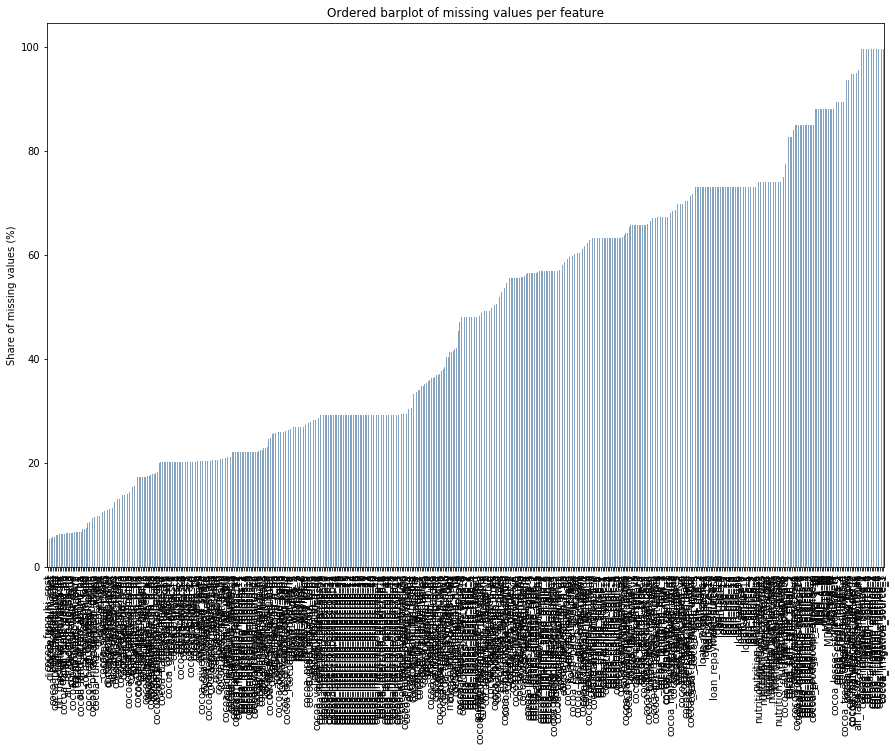

In [18]:
share_missing[share_missing>5].sort_values().plot.bar(figsize=(15,10), color=(0.2, 0.4, 0.6, 0.6))
plt.title("Ordered barplot of missing values per feature")
plt.ylabel("Share of missing values (%)")
plt.show()

Even though the graph is not readable, it confirms that some variables have many missing values.

Let's first take a look a the most problematic variables:

In [19]:
# problems:
problem = share_missing[share_missing>90]
print(len(problem), " problems")
list(problem.index)

24  problems


['all_land_leasedout_landunit_ha',
 'cocoa_trees_num',
 'cocoa_land_dec_how_5ago',
 'cocoa_trees_distance_known_yn',
 'cocoa_tree_spacing_trees',
 'cocoa_tree_spacing_rows',
 'cocoa_manurecomp_times',
 'cocoa_manurecomp_hh_hi',
 'cocoa_manurecomp_gender_1',
 'cocoa_manurecomp_gender_2',
 'cocoa_irrigation_source_1',
 'cocoa_irrigation_source_2',
 'cocoa_irrigation_source_3',
 'cocoa_irrigation_source_4',
 'cocoa_irrigation_source_5',
 'cocoa_irrigation_source_6',
 'cocoa_irrigation_source_7',
 'cocoa_irrigation_method_1',
 'cocoa_irrigation_method_2',
 'cocoa_irrigation_method_3',
 'cocoa_irrigation_method_4',
 'cocoa_irrigation_method_5',
 'cocoa_irrigation_method_6',
 'cocoa_irrigation_method_7']

We see from the above that the variables on irrigation source is missing (since no one irrigates cocoa). These can be droped. 

We see that the variables on tree numbers and spacing can also be dropped. Similar to all land leased out.

In [23]:
data.drop([ 
 'all_land_leasedout_landunit_ha',
 'cocoa_trees_num',
 'cocoa_land_dec_how_5ago',
 'cocoa_trees_distance_known_yn',
 'cocoa_tree_spacing_trees',
 'cocoa_tree_spacing_rows',], axis = 1, inplace = True)

Check that indeed (almost) no one irrigates cocoa:

In [24]:
data['cocoa_irrigation_yn'].value_counts()

KeyError: 'cocoa_irrigation_yn'

In [25]:
data.drop(list(data.filter(regex = 'irrigation')), axis = 1, inplace = True) # drop respondent variables

The list above also showed missing values for times, hh_hi and gender in manure application. This is likely because the application of manure was `no` for most farmers. Let's double check:

In [26]:
data['cocoa_manurecomp_yn'].value_counts()

no     1929
yes     106
Name: cocoa_manurecomp_yn, dtype: int64

In [ ]:
def convert_tocodes(data, data_properties, label_name):
    
    columns = list(data.columns)
    for i in range(len(columns)):
        if data_properties.lbllist[i] == label_name:
            data[columns[i]] = data[columns[i]].cat.codes
            data.loc[data[columns[i]] == -1,columns[i]] = np.nan   
            
    return data
    

In [ ]:
data['head_gender']

In [ ]:
data = convert_tocodes(data, data_properties, "lblYESNO")
data = convert_tocodes(data, data_properties, "lblMALE_FEMALE")

In [ ]:
data.rename(columns =  data_properties.variable_labels(), inplace = True )

In [ ]:
data.head()

In [ ]:
list(data.columns)

In [31]:
data['country'].value_counts()

Ghana    1008
CdI       447
Name: country, dtype: int64